In [15]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install matplotlib
!python -m pip install --upgrade pip
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install pyngrok
!pip install opencv-python

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (2449.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0+cu121
    Uninstalling torch-2.2.0+cu121:
      Successfully uninstalled torch-2.2.0+cu121


In [16]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Đường dẫn đến thư mục dataset
dataset_path = "E:/banana_classification"

# Kích thước ảnh và batch size
image_size = (224, 224)
batch_size = 32

# Định nghĩa các phép biến đổi cho ảnh
transform = transforms.Compose([
    transforms.Resize(image_size),          # Resize ảnh về kích thước 224x224
    transforms.ToTensor(),                  # Chuyển đổi ảnh thành Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Chuẩn hóa với giá trị mean/std
                         std=[0.229, 0.224, 0.225])
])

# Tạo hàm lấy đường dẫn dữ liệu
class DataPathLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir

    def get_data_path(self, folder_name):
        return os.path.join(self.root_dir, folder_name)

# Khởi tạo DataPathLoader
path_loader = DataPathLoader(dataset_path)

# Tạo dataset cho train, validation và test
train_ds = datasets.ImageFolder(path_loader.get_data_path("train"), transform=transform)
val_ds = datasets.ImageFolder(path_loader.get_data_path("valid"), transform=transform)
test_ds = datasets.ImageFolder(path_loader.get_data_path("test"), transform=transform)

# Tạo DataLoader cho train, validation và test
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Kiểm tra cấu trúc dataset
print(f"Train dataset size: {len(train_ds)} samples")
print(f"Validation dataset size: {len(val_ds)} samples")
print(f"Test dataset size: {len(test_ds)} samples")

# In một batch dữ liệu từ train_loader và val_loader
train_iter = iter(train_loader)
images, labels = next(train_iter)
print(f"Train Batch - Image Shape: {images.shape}, Labels: {labels.shape}")

val_iter = iter(val_loader)
images, labels = next(val_iter)
print(f"Validation Batch - Image Shape: {images.shape}, Labels: {labels.shape}")


Train dataset size: 7773 samples
Validation dataset size: 735 samples
Test dataset size: 377 samples
Train Batch - Image Shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
Validation Batch - Image Shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


Class names: ['overripe', 'ripe', 'unripe']


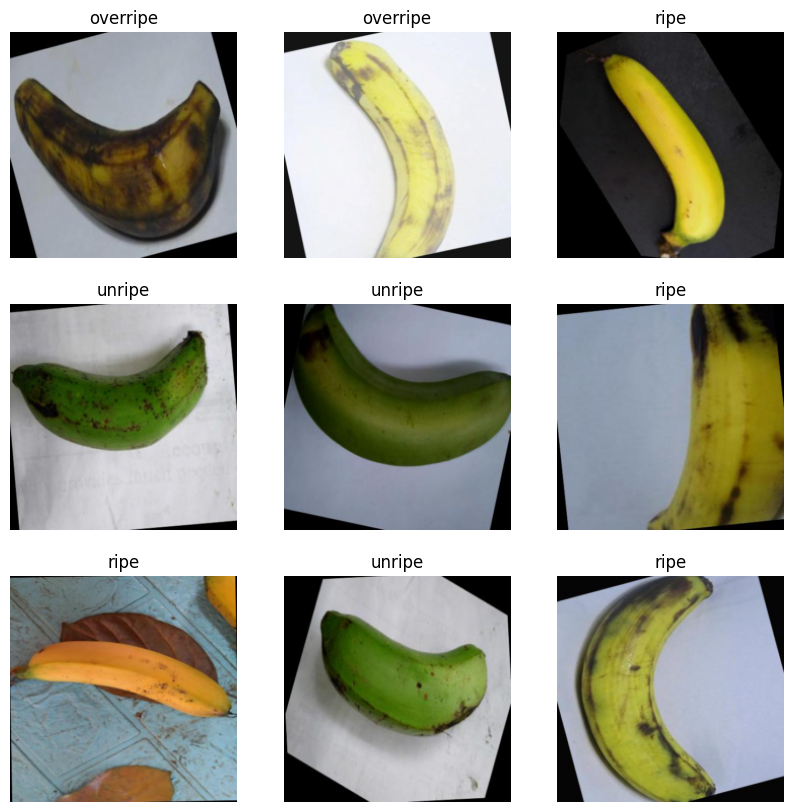

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Hiển thị 9 ảnh từ dataset
def show_images(dataset_loader, class_names):
    plt.figure(figsize=(10, 10))
    images, labels = next(iter(dataset_loader))  # Lấy batch đầu tiên
    for i in range(9):  # Hiển thị 9 ảnh đầu tiên
        ax = plt.subplot(3, 3, i + 1)
        # Chuyển đổi ảnh từ Tensor sang định dạng hiển thị
        img = images[i].permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) sang (H, W, C)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Bỏ chuẩn hóa
        img = np.clip(img, 0, 1)  # Giới hạn giá trị trong khoảng [0, 1]
        plt.imshow(img)
        plt.title(class_names[labels[i].item()])
        plt.axis("off")
    plt.show()

# In danh sách tên các lớp
class_names = train_ds.classes
print("Class names:", class_names)
import torchvision.transforms as transforms

# Định nghĩa các lớp augmentation
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang với xác suất 50%
    transforms.RandomRotation(degrees=10)   # Xoay ngẫu nhiên trong khoảng [-10, 10] độ
])

# Hàm áp dụng augmentation
def apply_data_augmentation(images):
    return data_augmentation(images)
import torch
from torchvision import transforms

# Hàm xử lý trước cho ảnh
def preprocess_image(image, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),         # Resize ảnh về 224x224
        transforms.ToTensor(),                # Chuyển đổi ảnh thành Tensor
        transforms.Normalize(mean=[0.0], std=[1.0])  # Chuẩn hóa giá trị pixel về [0, 1]
    ])
    image = transform(image)
    return image, label

# Hiển thị ảnh
show_images(train_loader, class_names)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), num_classes=3):
        super(CustomModel, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Entry block
        self.rescaling = nn.Identity()  # Giá trị đã chuẩn hóa ở pipeline trước đó
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)

        # Middle blocks
        self.middle_blocks = nn.ModuleList()
        previous_channels = 128
        for size in [256, 512, 728]:
            block = nn.ModuleDict({
                "sepconv1": nn.Conv2d(previous_channels, size, kernel_size=3, padding=1, groups=1),
                "bn1": nn.BatchNorm2d(size),
                "sepconv2": nn.Conv2d(size, size, kernel_size=3, padding=1, groups=1),
                "bn2": nn.BatchNorm2d(size),
                "residual_conv": nn.Conv2d(previous_channels, size, kernel_size=1, stride=2, padding=0),
                "pool": nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            })
            self.middle_blocks.append(block)
            previous_channels = size

        # Final layers
        self.sepconv_final = nn.Conv2d(728, 1024, kernel_size=3, padding=1, groups=1)
        self.bn_final = nn.BatchNorm2d(1024)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout_final = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Entry block
        x = self.rescaling(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        previous_block_activation = x

        # Middle blocks
        for block in self.middle_blocks:
            residual = block["residual_conv"](previous_block_activation)
            x = F.relu(block["bn1"](block["sepconv1"](x)))
            x = self.dropout1(x)
            x = F.relu(block["bn2"](block["sepconv2"](x)))
            x = self.dropout1(x)
            x = block["pool"](x)
            x += residual
            previous_block_activation = x

        # Final layers
        x = F.relu(self.bn_final(self.sepconv_final(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_final(x)
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Tạo mô hình
model = CustomModel(input_shape=(3, 224, 224), num_classes=3)

# Tóm tắt mô hình
print(model)


ModuleNotFoundError: No module named 'torch'

Using device: cuda


Epoch 1/1 - Training: 100%|██████████| 243/243 [02:58<00:00,  1.36it/s]


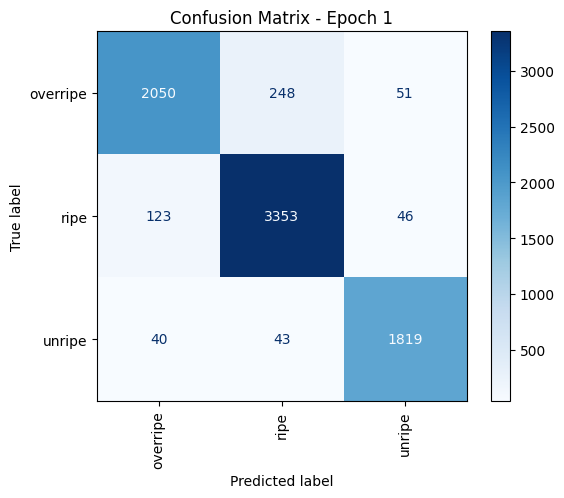

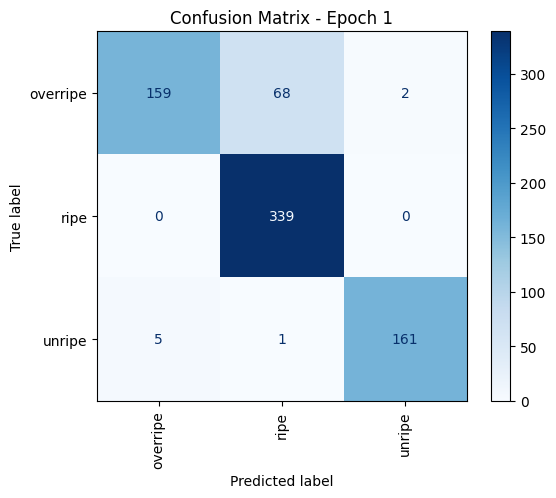

Epoch 1/1, Train Loss: 0.6278, Train Acc: 0.9291, Val Loss: 0.6601, Val Acc: 0.8966
Model saved to banana_ripeness_model.pth


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Đảm bảo mô hình được chạy trên GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hàm vẽ confusion matrix
def plot_confusion_matrix(labels, preds, classes, epoch):
    cm = confusion_matrix(labels, preds, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.show()

# Hàm huấn luyện
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, class_names):
    model = model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Lưu label và prediction để vẽ confusion matrix
        all_labels = []
        all_preds = []

        # Huấn luyện trên tập train
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Vẽ confusion matrix cho tập train
        plot_confusion_matrix(all_labels, all_preds, class_names, epoch)

        # Đánh giá trên tập val
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Vẽ confusion matrix cho tập val
        plot_confusion_matrix(all_val_labels, all_val_preds, class_names, epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, history

# Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tên các lớp (class names) trong bộ dữ liệu
class_names = ["overripe", "ripe", "unripe"]  # Thay bằng tên các lớp của bạn

# Huấn luyện mô hình
num_epochs = 1
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, class_names)

# Lưu mô hình
torch.save(model.state_dict(), "banana_ripeness_model.pth")
print("Model saved to banana_ripeness_model.pth")


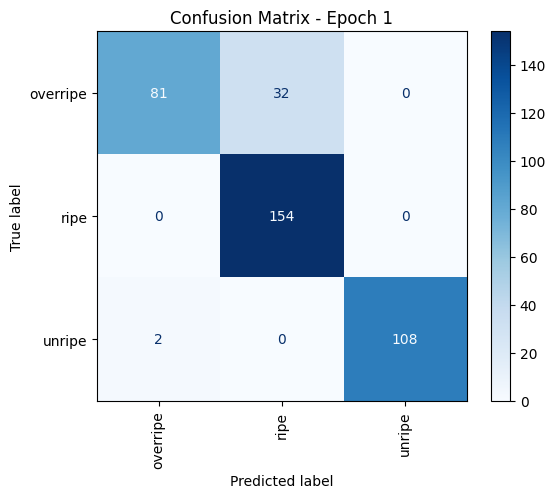

Test Loss: 0.6497
Test Accuracy: 90.98%


In [20]:
# Đánh giá mô hình trên tập kiểm tra
def evaluate_model(model, test_loader, criterion, class_names):
    model.eval()  # Chuyển sang chế độ đánh giá
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    # Vẽ confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names, epoch=0)  # epoch=0 vì chỉ đánh giá

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    return test_loss, test_acc


# Kiểm tra mô hình trên tập kiểm tra
test_loss, test_acc = evaluate_model(model, test_loader, criterion, class_names)
